In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

import numba

## Problem 1

#### Set up initial conditions

In [ ]:
seed = 5008 

def set_intitial_conditions(N):
    '''
    Set initial particle conditions as a random int from 0 to 100 along each axis.
    '''
    np.random.seed(seed) # reseed the initial conditions for reproducibility
    x = np.random.uniform(0, 100, N)
    y = np.random.uniform(0, 100, N)
    z = np.random.uniform(0, 100, N)
    return x, y, z

#### Direct method to calculate acceleration

In [ ]:
# I use the numba python package, which compiles code JIT (at runtime)
# to speed up the runs. The scaling of the acceleration function should
# not be changed by this, since the operations grow with the same time
# complexity, but it makes the total runtime more manageable
@numba.njit
def acceleration(x, y, z):
    '''
    Acceleration of each particle using the brute-force method (direct)
    '''
    # empty arrays for acceleration of each particle
    ax = np.zeros_like(x)
    ay = np.zeros_like(y)
    az = np.zeros_like(z)

    # calculate the distance between each pair of particles
    for i in range(len(x)):
        # we can save some calculations by noting that the distance between particles
        # i and j is the same as between j and i. So only need to iterate over half of the pairs
        for j in range(i + 1, len(x)):
            dx = x[j] - x[i]
            dy = y[j] - y[i]
            dz = z[j] - z[i]
            r = np.sqrt(dx**2 + dy**2 + dz**2)
            if r == 0:
                continue # each particle has no acceleration on itself
            a = 1 / r**2 # assuming GM = 1

            # add the acceleration of i on j
            ax[i] += a * dx / r
            ay[i] += a * dy / r
            az[i] += a * dz / r

            # to use the trick above, we need to add the acceleration of j on i
            ax[j] -= a * dx / r 
            ay[j] -= a * dy / r
            az[j] -= a * dz / r
    
    return ax, ay, az

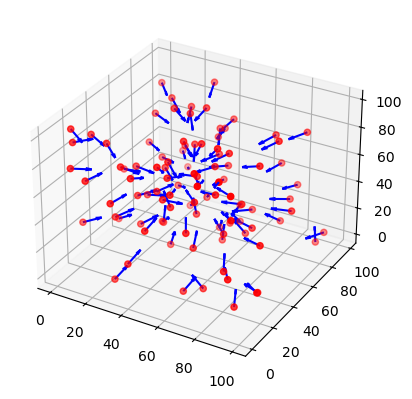

In [ ]:
# for fun, a 3d scatter plot with arrows for the acceleration of each particle
# to visualize what we're computing in this problem

x, y, z = set_intitial_conditions(100) # generate 100 random particles
ax, ay, az = acceleration(x, y, z) # calculate their accelerations

# plot the points in 3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='r', marker='o')

# plot the acceleration of each particle
for i in range(len(x)):
    plt.quiver(x[i], y[i], z[i], ax[i], ay[i], az[i], length=10, normalize=True, color='b')

#### KDTree method

In [ ]:
# get the acceleration from each particle given a list of 
@numba.njit
def acceleration_kdtree(x, y, z, ds):
    '''
    Acceleration of each particle using the kdtree method.
    Takes ds, a list of indices for each particle, queried from the KDTree.
    x, y, and z are the positions of the particles to calculate the acceleration for.
    '''
    # empty arrays for acceleration of each particle
    ax = np.zeros_like(x)
    ay = np.zeros_like(y)
    az = np.zeros_like(z)

    for i in range(len(x)):
        # get the nearest neighbor particles from the indices
        neighbors = ds[1][i][1:]
        for j in neighbors:

            # same calculations from here as the direct method, but we can't use the
            # reciprocal acceleration trick because one particle being another's neighbor
            # doesn't mean the other is a neighbor (eg. asymmetry)
            dx = x[j] - x[i]
            dy = y[j] - y[i]
            dz = z[j] - z[i]
            r = np.sqrt(dx**2 + dy**2 + dz**2)
            if r == 0:
                continue
            a = 1 / r**2
            ax[i] += a * dx / r
            ay[i] += a * dy / r
            az[i] += a * dz / r
    return ax, ay, az

#### Run both methods for range of Ns and compare timing

Brute-force:  0.0015411376953125
KDTree:  0.0167999267578125


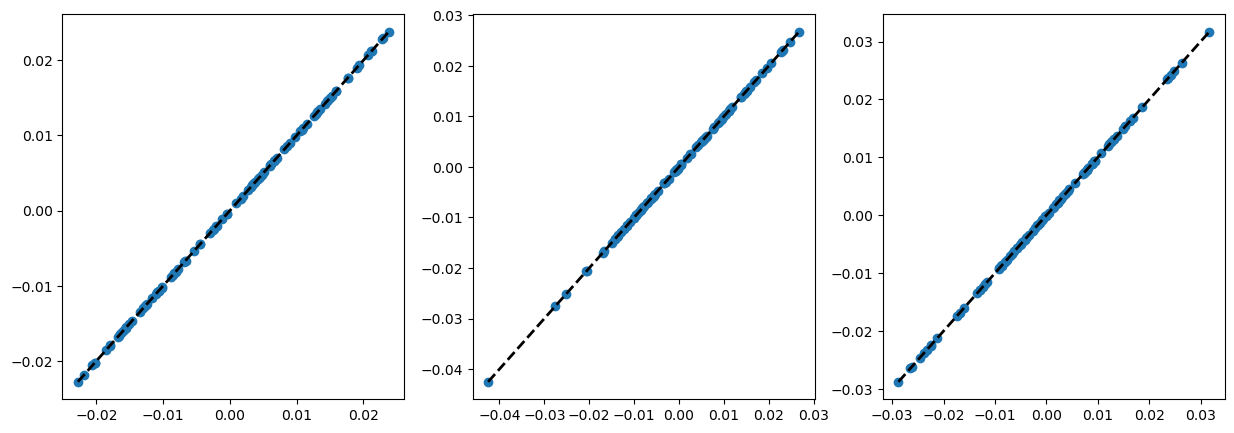

Brute-force:  0.002499103546142578
KDTree:  0.016592025756835938


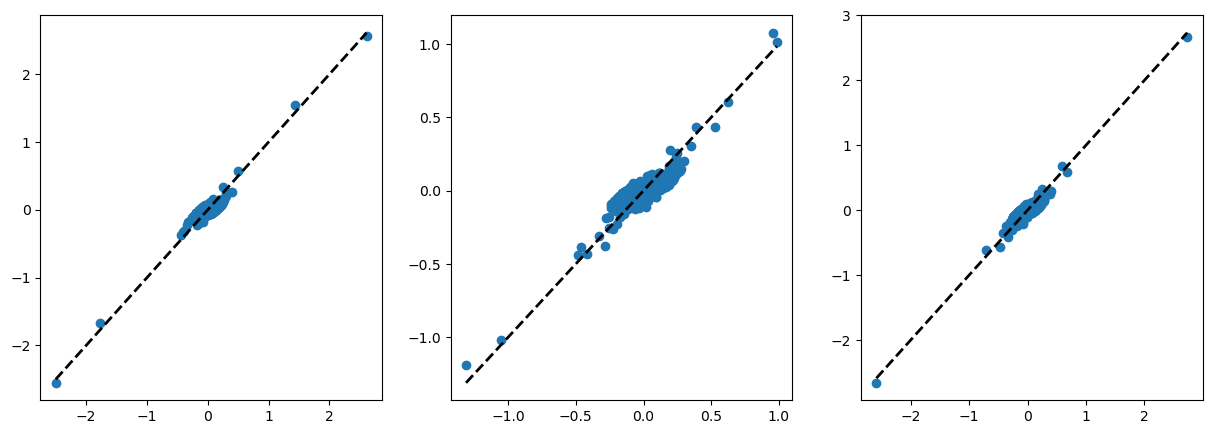

Brute-force:  0.23086905479431152
KDTree:  0.11406588554382324


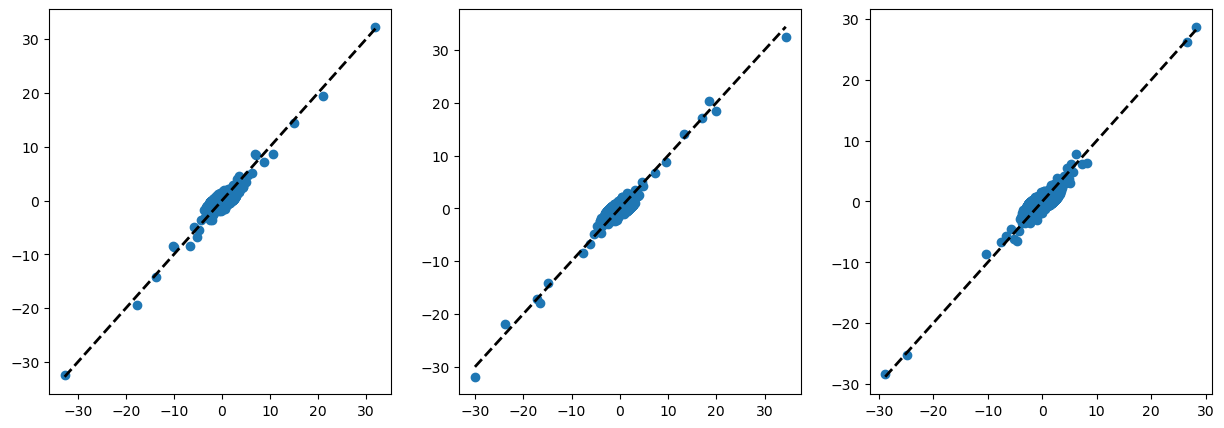

Brute-force:  21.375077962875366
KDTree:  1.5659348964691162


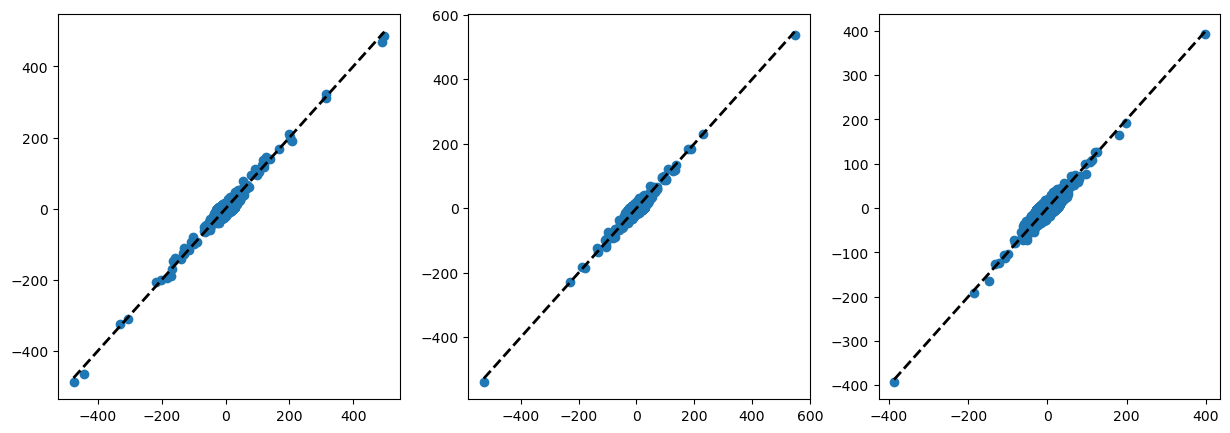

Brute-force:  2241.0175008773804
KDTree:  19.800846099853516


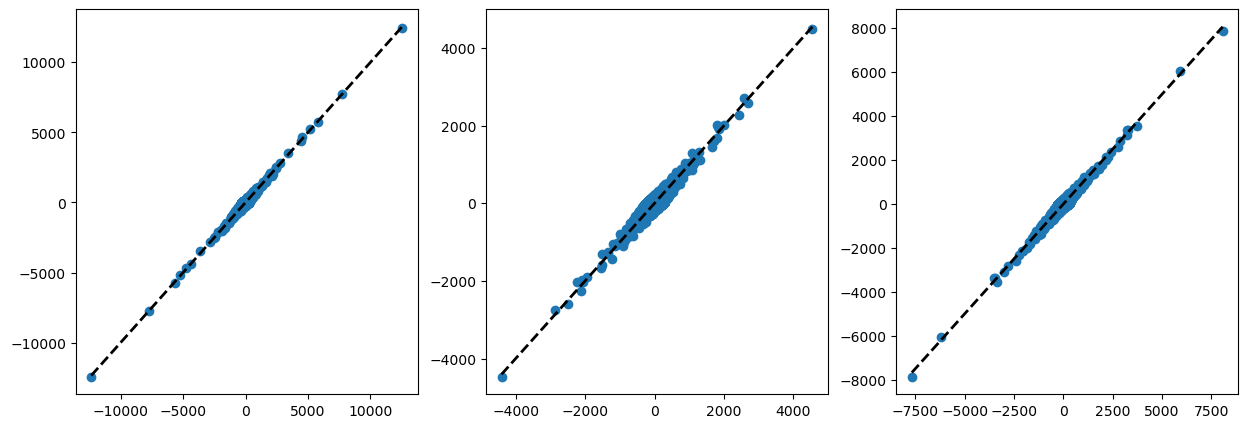

In [ ]:
import time

ts_brute = [] # store the times for the direct method
ts_kd = [] # store the times for the KDTree method

# time the acceleration function using the brute-force and KDtree methods
Ns = [100, 1000, 10000, 100000, 1000000]
for N in Ns:
    # set up the initial conditions
    x, y, z = set_intitial_conditions(N)

    # run and time the direct method
    start = time.time()
    ax, ay, az = acceleration(x, y, z)
    end = time.time()

    ts_brute.append(end - start)
    print("Brute-force: ", end - start)

    # run and time the KDTree method, including making and querying the tree
    start = time.time()
    tree = KDTree(np.array([x, y, z]).T)

    # for the KDTree method, I pick the 100 nearest neighbors, since this seemed
    # to present the best balance between speed and accuracy
    ds = tree.query(np.array([x, y, z]).T, k=100)
    ax_kd, ay_kd, az_kd = acceleration_kdtree(x, y, z, ds)
    end = time.time()

    ts_kd.append(end - start)
    print("KDTree: ", end - start)

    # plot a scatter plot showing the acceleration of each particle, KDTree vs direct
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].scatter(ax, ax_kd)
    axes[0].plot([ax.min(), ax.max()], [ax.min(), ax.max()], 'k--', lw=2)
    axes[1].scatter(ay, ay_kd)
    axes[1].plot([ay.min(), ay.max()], [ay.min(), ay.max()], 'k--', lw=2)
    axes[2].scatter(az, az_kd)
    axes[2].plot([az.min(), az.max()], [az.min(), az.max()], 'k--', lw=2)
    plt.show()

As we can see, across the entire range of particles tested, the KDTree method (considering only the 100 nearest neighbors to each particle to calculate the acceleration on them) is fairly accurate. Its results agree with the direct method quite closely across the range of accelerations. There do seem to be some systematic biases close to when the true acceleration is small. These are likely to be particles close to the edge of the box.

To see why, consider particles close to the center of the box. We directly compute the acceleration from its 100 nearest neighbors. If the particle is close to the center, the cumulative gravitational tugs from particles all around it are likely to roughly cancel out, making the KDTree query method fairly accurate in this case. On the other hand, if the particle is on the peripheries, then the cumulative effects from the non-neighbors may actually be non-negligible.

A good way to alleviate this problem in an actual N-body simulation would be to use a Barnes-Hut method with a structure like a quad/octree, where one can lump the effects of non-neighbors together for mimimal extra computational cost but improved accuracy. Indeed, I show below that my KDTree method has time complecity of appxoximately O(nlog(n)), the same as a Barnes-Hut algorithm with a quad/octree.

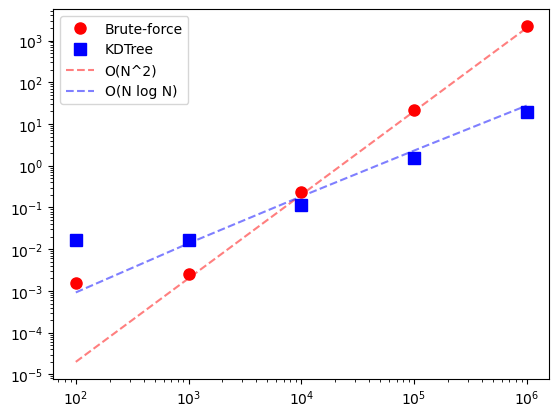

In [ ]:
# compare the timings as a function of N for both method
plt.loglog(Ns, ts_brute, 'o', markersize=8, c='r', label='Brute-force')
plt.loglog(Ns, ts_kd, 's', markersize=8, c='b', label='KDTree')

# assume the time complexities expected (see discussion below)
plt.loglog(Ns, [2e-9 * N**2 for N in Ns], 'r--', alpha=0.5, label='O(N^2)', zorder=-1)
plt.loglog(Ns, [2e-6 * N * np.log(N) for N in Ns], 'b--', alpha=0.5, label='O(N log N)', zorder=-1)
plt.legend()

The timings are comparable for small N, but the KDTree is significantly faster as N gets very large. This is because the KDTree method has time complexity of approximately O(nlog(n)), whereas the direct method goes like O(n^2).